<a href="https://colab.research.google.com/github/adriari4/lab-sql-generation-with-transformer-api/blob/main/lab-sql-generation-with-transformer-api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SQL Generation with Transformer API

In [2]:
!pip install torch transformers bitsandbytes accelerate sqlparse

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [4]:
torch.cuda.is_available()

True

In [5]:
available_memory = torch.cuda.get_device_properties(0).total_memory

In [6]:
print(available_memory)

15828320256


##Download the Model
Use any model on Colab (or any system with >30GB VRAM on your own machine) to load this in f16. If unavailable, use a GPU with minimum 8GB VRAM to load this in 8bit, or with minimum 5GB of VRAM to load in 4bit.

This step can take around 5 minutes the first time. So please be patient :)

In [7]:
model_name = "defog/sqlcoder-7b-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if available_memory > 15e9:
    # if you have atleast 15GB of GPU memory, run load the model in float16
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        torch_dtype=torch.float16,
        device_map="auto",
        use_cache=True,
    )
else:
    # else, load in 8 bits – this is a bit slower
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        # torch_dtype=torch.float16,
        load_in_8bit=True,
        device_map="auto",
        use_cache=True,
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

##Set the Question & Prompt and Tokenize
Feel free to change the schema in the prompt below to your own schema

In [8]:
prompt = """### Task
Generate a SQL query to answer [QUESTION]{question}[/QUESTION]

### Instructions
- If you cannot answer the question with the available database schema, return 'I do not know'
- Remember that revenue is price multiplied by quantity
- Remember that cost is supply_price multiplied by quantity

### Database Schema
This query will run on a database whose schema is represented in this string:
CREATE TABLE products (
  product_id INTEGER PRIMARY KEY, -- Unique ID for each product
  name VARCHAR(50), -- Name of the product
  price DECIMAL(10,2), -- Price of each unit of the product
  quantity INTEGER  -- Current quantity in stock
);

CREATE TABLE customers (
   customer_id INTEGER PRIMARY KEY, -- Unique ID for each customer
   name VARCHAR(50), -- Name of the customer
   address VARCHAR(100) -- Mailing address of the customer
);

CREATE TABLE salespeople (
  salesperson_id INTEGER PRIMARY KEY, -- Unique ID for each salesperson
  name VARCHAR(50), -- Name of the salesperson
  region VARCHAR(50) -- Geographic sales region
);

CREATE TABLE sales (
  sale_id INTEGER PRIMARY KEY, -- Unique ID for each sale
  product_id INTEGER, -- ID of product sold
  customer_id INTEGER,  -- ID of customer who made purchase
  salesperson_id INTEGER, -- ID of salesperson who made the sale
  sale_date DATE, -- Date the sale occurred
  quantity INTEGER -- Quantity of product sold
);

CREATE TABLE product_suppliers (
  supplier_id INTEGER PRIMARY KEY, -- Unique ID for each supplier
  product_id INTEGER, -- Product ID supplied
  supply_price DECIMAL(10,2) -- Unit price charged by supplier
);

-- sales.product_id can be joined with products.product_id
-- sales.customer_id can be joined with customers.customer_id
-- sales.salesperson_id can be joined with salespeople.salesperson_id
-- product_suppliers.product_id can be joined with products.product_id

### Answer
Given the database schema, here is the SQL query that answers [QUESTION]{question}[/QUESTION]
[SQL]
"""

##Generate the SQL
This can be excruciatingly slow on a T4 in Colab, and can take 10-20 seconds per query. On faster GPUs, this will take ~1-2 seconds

Ideally, you should use `num_beams`=4 for best results. But because of memory constraints, we will stick to just 1 for now.

In [40]:
import sqlparse

def generate_query(question):
    updated_prompt = prompt.format(question=question)
    inputs = tokenizer(updated_prompt, return_tensors="pt").to("cuda")
    generated_ids = model.generate(
        **inputs,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=400,
        do_sample=False,
        num_beams=1,
    )
    outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    # empty cache so that you do generate more results w/o memory crashing
    # particularly important on Colab – memory management is much more straightforward
    # when running on an inference service
    return sqlparse.format(outputs[0].split("[SQL]")[-1], reindent=True)

In [10]:
question = "What was our revenue by product in the New York region last month?"
generated_sql = generate_query(question)

In [11]:
print(generated_sql)


SELECT p.product_id,
       SUM(s.quantity * p.price) AS revenue
FROM sales s
JOIN salespeople sp ON s.salesperson_id = sp.salesperson_id
JOIN products p ON s.product_id = p.product_id
WHERE sp.region = 'New York'
  AND s.sale_date >= (CURRENT_DATE - INTERVAL '1 month')
GROUP BY p.product_id
ORDER BY revenue DESC NULLS LAST;


# Exercise
 - Complete the prompts similar to what we did in class.
     - Try at least 3 versions
     - Be creative


1ST ATTEMPT: CHEKING THE QUESTION OF MONDAYS S LAB

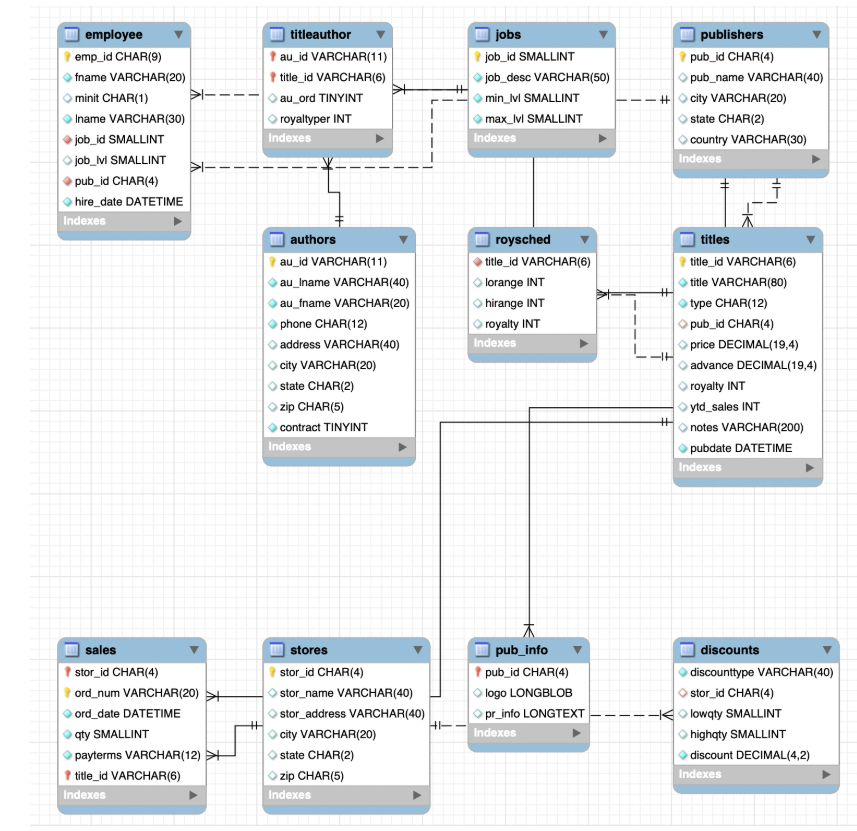

In [12]:
prompt = """### Task
Generate a SQL query to answer [QUESTION]{question}[/QUESTION]

### Instructions
- If you cannot answer the question with the available database schema, return 'I do not know'
- Remember that revenue is price multiplied by quantity (price * qty)
- Remember that royalties may depend on the royalty rate and sales
- Use appropriate JOINs according to the foreign key relationships

### Database Schema
This query will run on a database whose schema is represented in this string:

CREATE TABLE employee (
  emp_id CHAR(9) PRIMARY KEY,
  fname VARCHAR(20),
  minit CHAR(1),
  lname VARCHAR(30),
  job_id SMALLINT,
  job_lvl SMALLINT,
  pub_id CHAR(4),
  hire_date DATETIME
);

CREATE TABLE jobs (
  job_id SMALLINT PRIMARY KEY,
  job_desc VARCHAR(50),
  min_lvl SMALLINT,
  max_lvl SMALLINT
);

CREATE TABLE publishers (
  pub_id CHAR(4) PRIMARY KEY,
  pub_name VARCHAR(40),
  city VARCHAR(20),
  state CHAR(2),
  country VARCHAR(30)
);

CREATE TABLE titles (
  title_id VARCHAR(6) PRIMARY KEY,
  title VARCHAR(80),
  type CHAR(12),
  pub_id CHAR(4),
  price DECIMAL(19,4),
  advance DECIMAL(19,4),
  royalty INT,
  ytd_sales INT,
  notes VARCHAR(200),
  pubdate DATETIME
);

CREATE TABLE authors (
  au_id VARCHAR(11) PRIMARY KEY,
  au_lname VARCHAR(40),
  au_fname VARCHAR(20),
  phone CHAR(12),
  address VARCHAR(40),
  city VARCHAR(20),
  state CHAR(2),
  zip CHAR(5),
  contract TINYINT
);

CREATE TABLE titleauthor (
  au_id VARCHAR(11),
  title_id VARCHAR(6),
  au_ord TINYINT,
  royaltyper INT
);

CREATE TABLE roysched (
  title_id VARCHAR(6),
  lorange INT,
  hirange INT,
  royalty INT
);

CREATE TABLE stores (
  stor_id CHAR(4) PRIMARY KEY,
  stor_name VARCHAR(40),
  stor_address VARCHAR(40),
  city VARCHAR(20),
  state CHAR(2),
  zip CHAR(5)
);

CREATE TABLE sales (
  stor_id CHAR(4),
  ord_num VARCHAR(20),
  ord_date DATETIME,
  qty SMALLINT,
  payterms VARCHAR(12),
  title_id VARCHAR(6)
);

CREATE TABLE discounts (
  discounttype VARCHAR(40),
  stor_id CHAR(4),
  lowqty SMALLINT,
  highqty SMALLINT,
  discount DECIMAL(4,2)
);

CREATE TABLE pub_info (
  pub_id CHAR(4) PRIMARY KEY,
  logo LONGBLOB,
  pr_info LONGTEXT
);

-- Relationships
-- employee.job_id → jobs.job_id
-- employee.pub_id → publishers.pub_id
-- titles.pub_id → publishers.pub_id
-- titleauthor.title_id → titles.title_id
-- titleauthor.au_id → authors.au_id
-- roysched.title_id → titles.title_id
-- sales.title_id → titles.title_id
-- sales.stor_id → stores.stor_id
-- discounts.stor_id → stores.stor_id
-- pub_info.pub_id → publishers.pub_id

### Answer
Given the database schema, here is the SQL query that answers [QUESTION]{question}[/QUESTION]
[SQL]
"""


In [13]:
question = "Who Have Published What At Where?"
generated_sql = generate_query(question)

In [14]:
print(generated_sql)


SELECT a.au_fname,
       a.au_lname,
       t.title,
       p.pub_name,
       s.stor_name
FROM authors a
JOIN titleauthor ta ON a.au_id = ta.au_id
JOIN titles t ON ta.title_id = t.title_id
JOIN publishers p ON t.pub_id = p.pub_id
JOIN stores s ON s.stor_id = ta.title_id;


Challenge 2 - Who Have Published How Many At Where?
Challenge 3 - Best Selling Authors
Challenge 4 - Best Selling Authors Ranking

In [15]:
question = "Who Have Published How Many At Where??"
generated_sql2 = generate_query(question)

In [16]:
print(generated_sql2)


SELECT a.au_fname,
       a.au_lname,
       p.pub_name,
       COUNT(t.title_id) AS title_count,
       SUM(t.price * t.qty) AS total_revenue
FROM authors a
JOIN titleauthor ta ON a.au_id = ta.au_id
JOIN titles t ON ta.title_id = t.title_id
JOIN publishers p ON t.pub_id = p.pub_id
GROUP BY a.au_fname,
         a.au_lname,
         p.pub_name
ORDER BY title_count DESC;


In [17]:
question3 = "Best Selling Authors Challenge"
generated_sql3 = generate_query(question3)

In [18]:
print(generated_sql3)


SELECT a."au_fname",
       a."au_lname",
       SUM(t.price * s.qty) AS total_revenue
FROM authors a
JOIN titleauthor ta ON a.au_id = ta.au_id
JOIN titles t ON ta.title_id = t.title_id
JOIN sales s ON t.title_id = s.title_id
GROUP BY a."au_fname",
         a."au_lname"
ORDER BY total_revenue DESC
LIMIT 1;


In [19]:
question4 = "Best Selling Authors Ranking"
generated_sql4 = generate_query(question4)

In [20]:
print(generated_sql4)


SELECT a."au_fname",
       a."au_lname",
       SUM(t.price * s.qty) AS total_revenue
FROM authors a
JOIN titleauthor ta ON a.au_id = ta.au_id
JOIN titles t ON ta.title_id = t.title_id
JOIN sales s ON t.title_id = s.title_id
GROUP BY a."au_fname",
         a."au_lname"
ORDER BY total_revenue DESC;


**Changing the Prompt**

In [39]:
prompt = """### Task
Generate a SQL query to answer [QUESTION]{question}[/QUESTION]

### Instructions
- DO NOT use explicit JOIN syntax.
- If the question requires combining data from multiple tables,
use subqueries or WHERE clauses instead of JOINs.
- Instead, use comma-separated tables and WHERE clauses to connect them.
- Example:
  SELECT a.name, b.salary
  FROM employees a, salaries b
  WHERE a.id = b.emp_id;

### Database Schema
This query will run on a database whose schema is represented in this string:

CREATE TABLE employee (
  emp_id CHAR(9) PRIMARY KEY,
  fname VARCHAR(20),
  minit CHAR(1),
  lname VARCHAR(30),
  job_id SMALLINT,
  job_lvl SMALLINT,
  pub_id CHAR(4),
  hire_date DATETIME
);

CREATE TABLE jobs (
  job_id SMALLINT PRIMARY KEY,
  job_desc VARCHAR(50),
  min_lvl SMALLINT,
  max_lvl SMALLINT
);

CREATE TABLE publishers (
  pub_id CHAR(4) PRIMARY KEY,
  pub_name VARCHAR(40),
  city VARCHAR(20),
  state CHAR(2),
  country VARCHAR(30)
);

CREATE TABLE titles (
  title_id VARCHAR(6) PRIMARY KEY,
  title VARCHAR(80),
  type CHAR(12),
  pub_id CHAR(4),
  price DECIMAL(19,4),
  advance DECIMAL(19,4),
  royalty INT,
  ytd_sales INT,
  notes VARCHAR(200),
  pubdate DATETIME
);

CREATE TABLE authors (
  au_id VARCHAR(11) PRIMARY KEY,
  au_lname VARCHAR(40),
  au_fname VARCHAR(20),
  phone CHAR(12),
  address VARCHAR(40),
  city VARCHAR(20),
  state CHAR(2),
  zip CHAR(5),
  contract TINYINT
);

CREATE TABLE titleauthor (
  au_id VARCHAR(11),
  title_id VARCHAR(6),
  au_ord TINYINT,
  royaltyper INT
);

CREATE TABLE roysched (
  title_id VARCHAR(6),
  lorange INT,
  hirange INT,
  royalty INT
);

CREATE TABLE stores (
  stor_id CHAR(4) PRIMARY KEY,
  stor_name VARCHAR(40),
  stor_address VARCHAR(40),
  city VARCHAR(20),
  state CHAR(2),
  zip CHAR(5)
);

CREATE TABLE sales (
  stor_id CHAR(4),
  ord_num VARCHAR(20),
  ord_date DATETIME,
  qty SMALLINT,
  payterms VARCHAR(12),
  title_id VARCHAR(6)
);

CREATE TABLE discounts (
  discounttype VARCHAR(40),
  stor_id CHAR(4),
  lowqty SMALLINT,
  highqty SMALLINT,
  discount DECIMAL(4,2)
);

CREATE TABLE pub_info (
  pub_id CHAR(4) PRIMARY KEY,
  logo LONGBLOB,
  pr_info LONGTEXT
);

-- Relationships
-- employee.job_id → jobs.job_id
-- employee.pub_id → publishers.pub_id
-- titles.pub_id → publishers.pub_id
-- titleauthor.title_id → titles.title_id
-- titleauthor.au_id → authors.au_id
-- roysched.title_id → titles.title_id
-- sales.title_id → titles.title_id
-- sales.stor_id → stores.stor_id
-- discounts.stor_id → stores.stor_id
-- pub_info.pub_id → publishers.pub_id

### Answer
Given the database schema, here is the SQL query that answers [QUESTION]{question}[/QUESTION]
[SQL]
"""


In [41]:
question4b = "Best Selling Authors Ranking"
generated_sql4b = generate_query(question4b)

In [43]:
print(generated_sql4b)


SELECT a.au_fname,
       a.au_lname,
       COUNT(t.title_id) AS book_count
FROM authors a
JOIN titleauthor ta ON a.au_id = ta.au_id
JOIN titles t ON ta.title_id = t.title_id
GROUP BY a.au_fname,
         a.au_lname
ORDER BY book_count DESC;


 - Write a one page report summarizing your findings.
     - Were there variations that didn't work well? i.e., where GPT either hallucinated or wrong
 - What did you learn?

 What I learnt is how to use other different model, smaller than GPT, because on a company´s project I would not use a GPT because of costs and GPUs capacity. I learnt too:
 - Depends on the model you have to call the tokenizer or not, and then other steps like De-Tokenizer
 - I can not get the answer on they way that i want changing the prompt. Tthe model has some problems avoiding JOINS.